In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from hyperopt import fmin, tpe, hp
from pymongo import MongoClient
import seaborn as sns
from src.experiments.RFexp import ex as rfex
from src.experiments.XGBexp import ex as xgbex

/home/daria/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


This notebook shows how to use Sacred and Hyperopt to do automatic hyperparameter selection. 

[Sacred](https://github.com/IDSIA/sacred) is a tool for organizing, running and logging machine learning experiments. It comes with a mongo observer that saves the run's configuration and results to a mongo database. I found it very useful especially in conjunction with [Hyperopt](https://github.com/hyperopt/hyperopt) which is a Python library for hyperparameter optimization. 

See [the docs](http://sacred.readthedocs.org/en/latest/quickstart.html) on how to install and start using Sacred. 

I'll show an example using an experiment with a random forest algorithm for predicting fault severities for the "Telstra Network Discruptions" Kaggle competition. The code for this experiment is in [src/experiments/RFexp.py](https://github.com/gereleth/kaggle-telstra/blob/master/src/experiments/RFexp.py). There are other files in the [experiments](https://github.com/gereleth/kaggle-telstra/tree/master/src/experiments) folder with other algorithms I tried. 

The experiment's function decorated with `@ex.automain` loads the data, builds features, performs a stratified k-fold cross-validation and returns multiclass log loss as the result. Let's see how it works by running an experiment.

## Run an experiment

In [2]:
run = rfex.run()

INFO - random_forest - Running command 'rf'
INFO - random_forest - Started
INFO - random_forest - Result: 0.4609685816608816
INFO - random_forest - Completed after 0:00:32


See the configuration used for this run:

In [3]:
run.config

{'aggregateparams': {'loc_agg_prior_weight': 3.0},
 'clfparams': {'bootstrap': True,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': None,
  'max_features': 'auto',
  'max_leaf_nodes': None,
  'min_samples_leaf': 4,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 200,
  'n_jobs': -1,
  'oob_score': False,
  'verbose': 0,
  'warm_start': False},
 'exclude': [],
 'featureparams': {'location_min_count': 0,
  'n_common_events': 20,
  'n_common_log_features': 40,
  'n_common_resources': 5,
  'n_label_encoded_events': 0,
  'n_label_encoded_log_features': 4},
 'include': [],
 'n_folds': 10,
 'save_oob_predictions': False,
 'save_test_predictions': False,
 'seed': 884068221,
 'series': 'RF',
 'skip_cross_validation': False}

See the run's result:

In [4]:
run.result

0.46096858166088162

Additional information can be saved in the `run.info` dictionary. For example, in my RF experiment I save feature names, feature importances, values of loss and train loss from each fold.

In [5]:
run.info.keys()

dict_keys(['loss', 'features', 'trainloss', 'feature_importances'])

Let's plot some feature importances

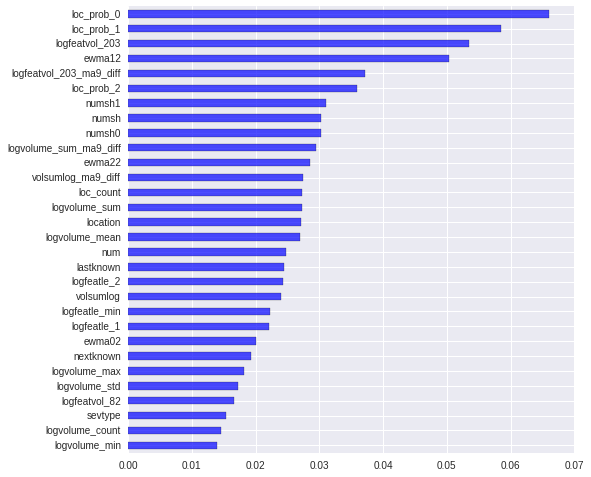

In [7]:
imp = pd.Series(run.info['feature_importances'],index=run.info['features']).sort_values()
fig, ax = plt.subplots(figsize=(8,8))
imp.iloc[-30:].plot(kind='barh',ax=ax, alpha = 0.7)

## Run an experiment with another configuration

Running an experiment with new configuration is done by using `config_updates` keyword argument. For example, let's set `max_features` random forest parameter to 1. Note how Sacred warns us that it was changed from string ('auto') to an int.

In [34]:
run = rfex.run(config_updates = {"clfparams.max_features":1})

WARNING - root - Changed type of config entry "clfparams.max_features" from str to int
INFO - random_forest - Running command 'rf'
INFO - random_forest - Started
INFO - random_forest - Result: 0.5732386736378875
INFO - random_forest - Completed after 0:00:29


We can change multiple things at once. For example, let's not take any one-hot encoded events columns, change `max_features` to 2 and exclude the location feature. This is just to show how config updates work.

In [35]:
run = rfex.run(config_updates = {"clfparams.max_features":2,
                                 "featureparams.n_common_events":0,
                                 "exclude":['location']})

WARNING - root - Changed type of config entry "clfparams.max_features" from str to int
INFO - random_forest - Running command 'rf'
INFO - random_forest - Started
INFO - random_forest - Result: 0.5167924399116657
INFO - random_forest - Completed after 0:00:29


Rerunning an experiment with the same config should give exactly the same result. Let's check if it does.

In [36]:
rerun = rfex.run(config_updates = run.config)

WARNING - root - Changed type of config entry "clfparams.max_features" from str to int
INFO - random_forest - Running command 'rf'
INFO - random_forest - Started
INFO - random_forest - Result: 0.5167924399116657
INFO - random_forest - Completed after 0:00:29


Sacred takes care of setting the random seed (of `random` and `numpy.random`) and saves the seed in the configuration. So you can always reproduce any experiment you ran.

## Tune the model with hyperopt

Let's try tuning the random forest model using `hyperopt` library. Let's say that we want to select optimal values for `max_features` and `min_samples_leaf` parameters.

First we'll need to define a search space for the parameters. I set `max_features` to look over integers from 1 to 20 and `min_samples_leaf` to integers from 1 to 10. For details on defining search spaces see [hyperopt docs](https://github.com/hyperopt/hyperopt/wiki/FMin).

In [38]:
space = {'max_features':hp.quniform('max_features',1,20,1),
         'min_samples_leaf':hp.quniform('min_samples_leaf',1,10,1)}

Next we define the optimisation objective. Inside the function we create a dict of configuration updates, run the experiment and report the result.

In [39]:
def rf_objective(params):
    config={'series':"RF01"}
    for (key,value) in params.items():
        config["clfparams.{}".format(key)] = int(value)
    run = rfex.run(config_updates=config)
    return run.result

Now we can run the optimisation using `fmin` from hyperopt. `max_evals` number controls how many points to try in the hyperparameter space.

Time to launch the optimisation. Then you can have some tea or go for a walk or get a good night's sleep while the automatic tuning is working on improving your model.

In [40]:
best = fmin(fn=rf_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20)
print(best)

INFO - hyperopt.tpe - tpe_transform took 0.001224 seconds
INFO - hyperopt.tpe - TPE using 0 trials
WARNING - root - Changed type of config entry "clfparams.max_features" from str to int
INFO - random_forest - Running command 'rf'
INFO - random_forest - Started
INFO - random_forest - Result: 0.4618138426460098
INFO - random_forest - Completed after 0:00:34
INFO - hyperopt.tpe - tpe_transform took 0.001186 seconds
INFO - hyperopt.tpe - TPE using 1/1 trials with best loss 0.461814
WARNING - root - Changed type of config entry "clfparams.max_features" from str to int
INFO - random_forest - Running command 'rf'
INFO - random_forest - Started
INFO - random_forest - Result: 0.46043073364538084
INFO - random_forest - Completed after 0:00:35
INFO - hyperopt.tpe - tpe_transform took 0.000895 seconds
INFO - hyperopt.tpe - TPE using 2/2 trials with best loss 0.460431
WARNING - root - Changed type of config entry "clfparams.max_features" from str to int
INFO - random_forest - Running command 'rf'
I

{'max_features': 19.0, 'min_samples_leaf': 3.0}


## Review optimisation results

Notice how we didn't have to bother about saving any results or configurations. Sacred takes care of that for us. Let's look at the database entries for this optimisation run.

In [44]:
client = MongoClient()
db = client.telstra
runs = db.default.runs

How many runs were successfully completed?

In [45]:
runs.find({"config.series":"RF01","status":"COMPLETED"}).count()

20

Now let's collect configurations and results and put them in a dataframe.

In [57]:
def find():
    return runs.find({"config.series":"RF01","status":"COMPLETED"},sort = [('result',1)])
df = pd.DataFrame(0, index = np.arange(find().count()), columns = [])
for name in space.keys():
    df[name] = [r['config']['clfparams'][name] for r in find()]
df['result'] = [r['result'] for r in find()]
df = df.sort_values(by='result')
df.head()

,max_features,min_samples_leaf,result
0,19,3,0.453707
1,19,3,0.453742
2,16,3,0.455899
3,13,2,0.456388
4,8,2,0.456891


It looks like the best value for `min_samples_leaf` is 3, and best `max_features` is 19. But other settings also come close to the best result. 

We can visualize results as a seaborn pairplot.

/home/daria/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


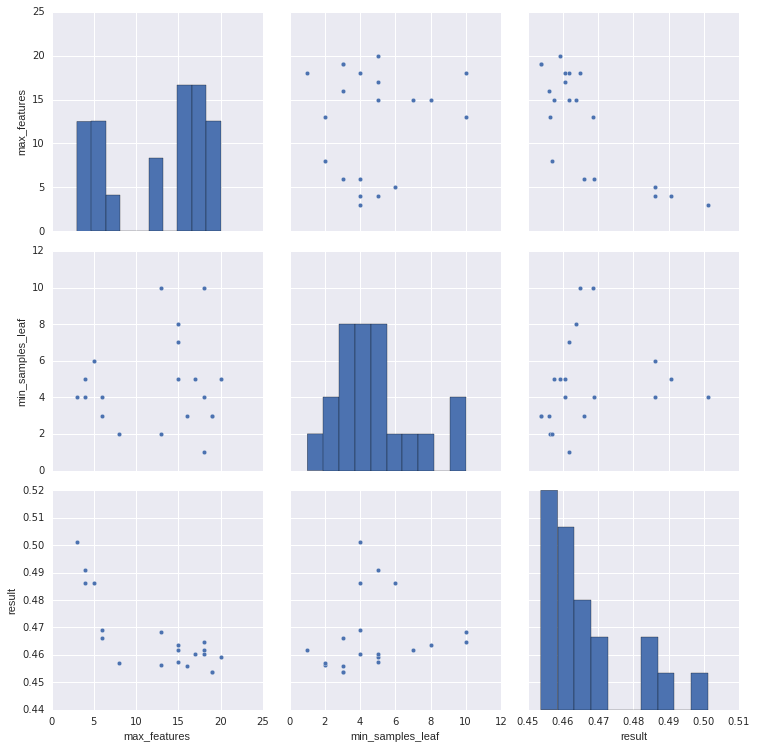

In [56]:
sns.pairplot(df,size=3.5)

It looks like more `max_features` is better. Maybe we could run another series of experiments this time allowing for `max_features` > 20. Or we can look at the results and select models for ensembling by finding those with similarly good results but sufficiently different settings. The decisions are up to you as a data scientist =).

## Tune an xgboost model

Here's an example of code I used for tuning xgboost for this competition.

In [ ]:
space = {'eta':hp.lognormal('eta',np.log(0.05),-np.log(0.1)),
         'max_depth':hp.quniform('max_depth',2,30,1),
         'subsample':hp.uniform('subsample',0.05,1.0),
         'colsample_bytree':hp.uniform('colsample_bytree',0.05,1.0),
         'lambda':hp.lognormal('lambda',np.log(10.),np.log(100)),
         'max_delta_step':hp.choice('max_delta_step', [0,1]),
         'alpha':hp.lognormal('alpha',np.log(1.),np.log(100.))}

In [ ]:
def xgboost_objective(params):
    config={'series':"XGB37"}
    for (key,value) in params.items():
        config["clfparams.{}".format(key)] = value
    run = xgbex.run(config_updates=config)
    return run.result

In [ ]:
best = fmin(fn=xgboost_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=200)

## Some notes on the tuning

* I sometimes did tuning in two stages: first a faster screening-type search over a larger set of configurations but using only a single train-validation split instead of full cross-validation. Then rerun full experiments with the best models found in stage one.
* It is possible to tune not only the model, but also the full pipeline including missing data handling, feature engineering and so on. We may have to make decisions like "how many features of this type to include", "fill NAs for this variable with -1, mean or median" etc. If we encode them as experiment configurations we can have hyperopt choose the best options as well.